Stitched 1D Frequency-Domain Inversion
=================================


Here we use the module *SimPEG.electromagnetics.frequency_domain* to perform
a stitched 1D inversion on a 3D FDEM (frequency-domain electromangetic)dataset. That is, we recover a local 1D
conductivity model for each sounding. In this tutorial, we focus on the following:

    - Defining receivers, sources and the survey for the stitched 1D case
    - Implementing a regularization that connects nearby 1D vertical conductivity profiles
    - Recovering a stitched model composed of a 1D vertical conductivity profile at each sounding location

For each sounding, the survey geometry consisted of a vertical magnetic dipole source
located 30 m above the Earth's surface. The receiver was offset
10 m horizontally from the source.


Import Modules
--------------

In [30]:
import numpy as np
from scipy.spatial import Delaunay, cKDTree
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from discretize import TensorMesh
from pymatsolver import PardisoSolver

from SimPEG import maps, utils
from SimPEG import (
    data, data_misfit, inverse_problem, regularization, optimization,
    directives, inversion, utils
)
from SimPEG.utils import mkvc
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.electromagnetics.utils.em1d_utils import plot_layer, get_vertical_discretization, set_mesh_1d, Stitched1DModel

plt.rcParams.update({'font.size': 16})
write_output = False


#####################################################################
# Create Survey
# -------------
#
# Here we demonstrate a general way to define receivers, sources and the survey.
# For this tutorial, we define a line of equally spaced 1D soundings along the
# Easting direction. However, there is no restriction on the spacing and position
# of each sounding.

nx = 11
ny = 5
x = np.arange(nx)*50 
y = np.arange(ny)*100
z = np.array([30.])

xyz = utils.ndgrid(x, y, z)
xyz[:,1] += np.random.randn(nx*ny) * 5 
n_sounding = xyz.shape[0]
source_locations = xyz  # xyz locations for the centre of the loop
moment = 1

receiver_locations = xyz.copy()   # xyz locations for the receivers
receiver_locations[:,0] = xyz[:,0] + 10.
receiver_orientation = "z"            # "x", "y" or "z"
data_type = "ppm"                            # "secondary", "total" or "ppm"


frequencies = np.array([25., 100., 382, 1822, 7970, 35920], dtype=float)

# For each sounding, we define the source and the associated receivers.
source_list = []
for ii in range(0, n_sounding):

    # Source and receiver locations
    source_location = mkvc(source_locations[ii, :])
    receiver_location = mkvc(receiver_locations[ii, :])

    # Define receiver list for source ii
    receiver_list = []
    receiver_list.append(
        fdem.receivers.PointMagneticFieldSecondary(
            receiver_location, orientation=receiver_orientation,
            data_type=data_type, component="both"
        )
    )

    # Define source ii at frequency jj
    for freq in frequencies:
        source_list.append(
            fdem.sources.MagDipole(
                receiver_list=receiver_list, frequency=freq, location=source_location,
                orientation="z", moment=moment, i_sounding=ii
            )
        )

# Survey
survey = fdem.survey.Survey(source_list)

>> Depth from the surface to the base of the bottom layer is 283.4m


C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(


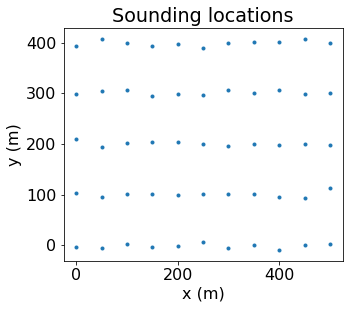

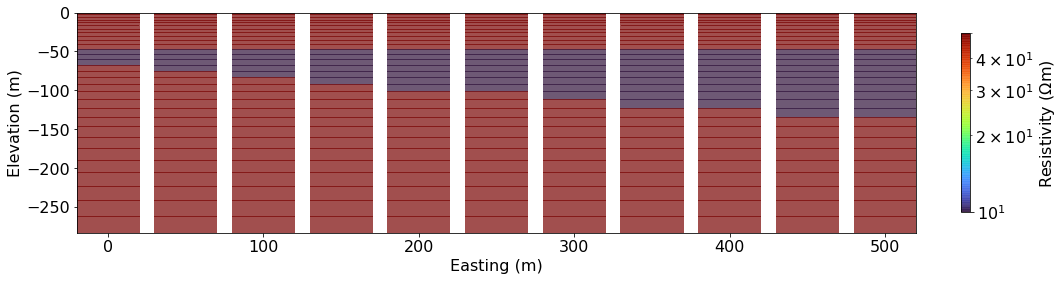

In [31]:
###############################################
# Defining a Global Mesh and Model
# --------------------------------
#
# It is easy to create and visualize 2D and 3D models in SimPEG, as opposed
# to an arbitrary set of local 1D models. Here, we create a 2D model
# which represents the global conductivity structure of the Earth. In the next
# part of the tutorial, we will demonstrate how the set of local 1D models can be
# extracted and organized for the stitched 1D simulation. This process can
# be adapted easily for 3D meshes and models.
#

# line number
line = (np.arange(ny).repeat(nx)).astype(float)
# time stamp
time_stamp = np.arange(n_sounding).astype(float)
# topography
topography = np.c_[xyz[:,:2], np.zeros(n_sounding)]
# vertical cell widths
hz = get_vertical_discretization(30, 3, 1.07)
# hz = 10*np.ones(30)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(xyz[:,0], xyz[:,1], '.')
ax.set_aspect(1)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Sounding locations")

# A function for generating a wedge layer 
def get_y(x):
    y = 70/500 * x + 70.    
    return y

# Conductivity values for each unit
background_conductivity = 1./50
layer_conductivity = 1./10

# Define a 1D vertical mesh
mesh_1d = set_mesh_1d(hz)
# Generate a stitched 1D model
n_layer = hz.size
conductivity = np.zeros((n_sounding, n_layer), dtype=float)

for i_sounding in range(n_sounding):
    y = get_y(xyz[i_sounding, 0])
    layer_ind = np.logical_and(mesh_1d.vectorCCx>50., mesh_1d.vectorCCx<y)
    conductivity_1d = np.ones(n_layer, dtype=float) * background_conductivity
    conductivity_1d[layer_ind] = layer_conductivity
    conductivity[i_sounding,:]=conductivity_1d

# Note: oder of the conductivity model 
stitched_conductivity_model = conductivity.flatten()

# Generate a Stitched1DModel object for plotting
model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    time_stamp=time_stamp,
    topography=topography,
    physical_property=1./stitched_conductivity_model
)

_, ax, cb = model_plot.plot_section(cmap='turbo', aspect=0.5, dx=20, i_line=0)
cb.set_label("Resistivity ($\Omega$m)")

# the optimum layer thicknesses for a set number of layers. Note that when defining
# the thicknesses, it is the number of layers minus one.
thicknesses = hz[:-1]

In [32]:
#######################################################################
# Define the Mapping, Forward Simulation and Predict Data
# -------------------------------------------------------
#
# Here we define the simulation and predict the TDEM data.
# The simulation requires the user define the survey, the layer thicknesses
# and a mapping from the model to the conductivities.
#
# When using the *SimPEG.electromagnetics.time_domain_1d* module, predicted
# data are organized by source (sounding), then by receiver, then by time channel.
#

# Model and mapping. Here the model is defined by the log-conductivity.
stitched_model = np.log(stitched_conductivity_model)
mapping = maps.ExpMap(nP=len(stitched_conductivity_model))

# Define the simulation
simulation = fdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=mapping,
    parallel=False, n_cpu=2, solver=PardisoSolver
)

# Predict data
dpred = simulation.dpred(stitched_model)

>> Serial version is used


In [33]:
dpred.shape

(660,)

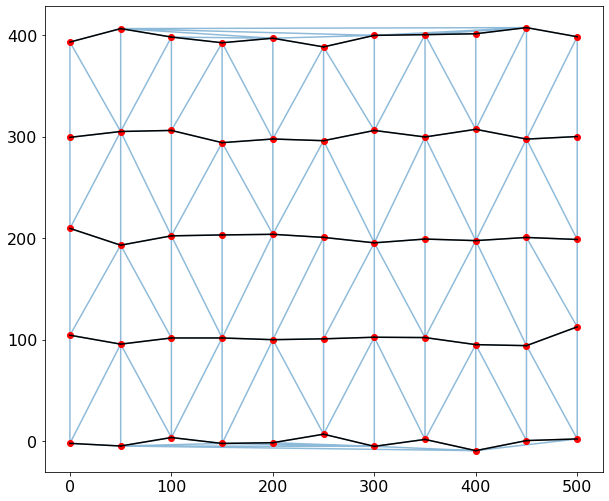

In [40]:
from SimPEG.electromagnetics.utils.em1d_utils import set_mesh_1d
import scipy as sp
from discretize import SimplexMesh
tri = sp.spatial.Delaunay(xyz[:,:2])
mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
mesh_reg = [mesh_radial, mesh_vertical]

def get_active_edge_indices_with_distance(mesh_radial, mesh_vertical, maximum_distance=1000):
    nz = mesh_vertical.n_cells
    edge_lengths = mesh_radial.edge_lengths
    inds = edge_lengths < maximum_distance
    indActiveEdges = np.tile(inds.reshape([-1,1]), nz).flatten()
    return inds, indActiveEdges

fig = plt.figure(figsize=(10, 10))
plt.triplot(xyz[:,0], xyz[:,1], tri.simplices[:,:], alpha=0.5)
plt.plot(xyz[:,0], xyz[:,1], 'ro')

inds, indActiveEdges = get_active_edge_indices_with_distance(
    mesh_radial, mesh_vertical, maximum_distance=80
)
fr = mesh_radial.nodes[mesh_radial._edges[inds,:][:,0],:]
to = mesh_radial.nodes[mesh_radial._edges[inds,:][:,1],:]

for ii in range(fr.shape[0]):
    plt.plot([fr[ii,0], to[ii,0]], [fr[ii,1], to[ii,1]], 'k')
plt.gca().set_aspect(1)

In [41]:
# Define the data object
np.random.seed(1)
uncertainties = abs(dpred) * 0.03
noise = np.random.randn(dpred.size)*abs(dpred)*0.03
dobs = dpred + noise
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
########################################################################
# Define Inverse Problem
# ----------------------
#
# The inverse problem is defined by 3 things:
#
#     1) Data Misfit: a measure of how well our recovered model explains the field data
#     2) Regularization: constraints placed on the recovered model and a priori information
#     3) Optimization: the numerical approach used to solve the inverse problem
#
#

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

# Define the regularization (model objective function). Here we use a laterally
# constrained regularization. This regularization connects the 1D models of
# nearby soundings and ensure lateral changes in electrical conductivity are
# sufficiently smooth.
n_param = len(stitched_conductivity_model)
mref = np.ones(n_param) * np.log(1./50.)
reg_map = maps.IdentityMap(nP=n_param)    # Mapping between the model and regularization
reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=reg_map,
    alpha_s = 1e-10,
    alpha_r = 1.,
    alpha_z = 1.,
#     gradientType=gradientType,
#     mref=mref
)

# # The laterally constrained case does support sparse norm inversion
ps, pr, pz = 2, 0, 0
reg.norms = np.c_[ps, pr, pz, 0]
starting_model = np.log(np.ones(n_param) * 1./20.)
# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter = 40, maxIterCG = 50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directiveas that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target = directives.TargetMisfit()
# Directives of the IRLS
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=30, 
    minGNiter=1,
    fix_Jmatrix=False,
    f_min_change = 1e-3,
    coolingRate=1,
    coolingFactor=2
)

# The directives are defined as a list.
directives_list = [
    starting_beta,
    beta_schedule,
    target
#     update_IRLS
]


#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)
opt.remember('xc')
# Run the invtersion
recovered_model = inv.run(starting_model)    

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.66e+00  1.33e+05  0.00e+00  1.33e+05    1.99e+04      0              
   1  3.83e+00  1.74e+04  3.81e+01  1.75e+04    3.93e+03      0              
   2  1.91e+00  3.31e+03  1.48e+02  3.59e+03    1.50e+03      0   Skip BFGS  
   3  9.57e-01  5.68e+02  2.11e+02  7.70e+02    4.12e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.3293e+04
1 : |xc-x_last| = 3.6217e+00 <= tolX*(1+|x0|) = 1.2269e+01
0 : |proj(x-g)-x|    = 4.1171e+02 <= tol

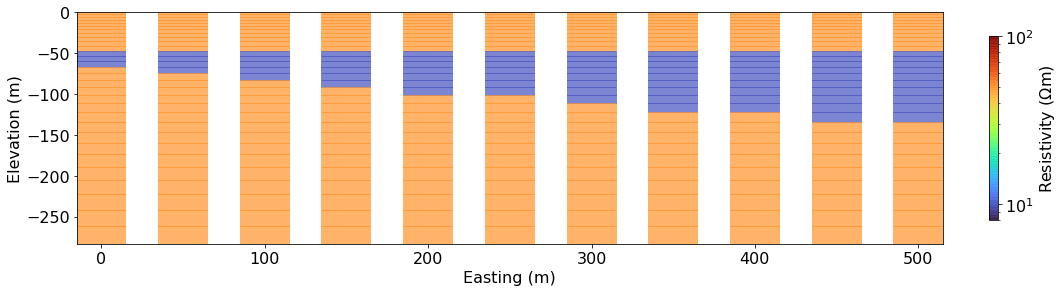

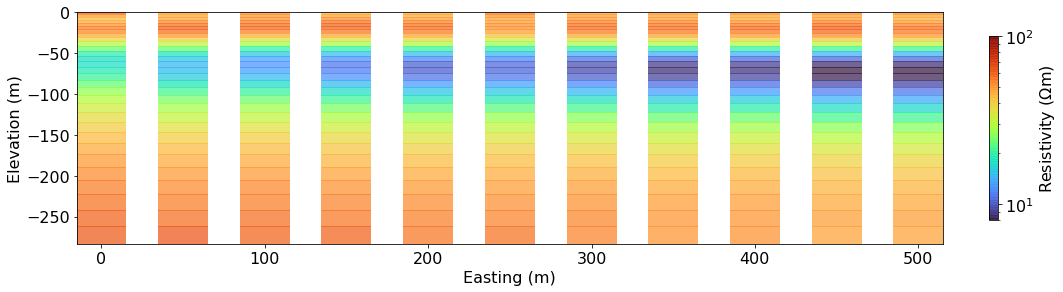

In [42]:
resistivity = 1./np.exp(recovered_model)

_, ax, cb = model_plot.plot_section(cmap='turbo', aspect=0.5, dx=15, i_line=0, clim=(8, 100))
cb.set_label("Resistivity ($\Omega$m)")
_, ax, cb = model_plot.plot_section(cmap='turbo', aspect=0.5, dx=15, i_line=0, physical_property=resistivity, clim=(8, 100))
cb.set_label("Resistivity ($\Omega$m)")

In [44]:
model_plot.get_3d_mesh(dx=20, dy=20)

TensorMesh: 17,500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     25          0.00        500.00     20.00     20.00    1.00
   y     20         -9.48        390.52     20.00     20.00    1.00
   z     35       -280.22         -0.00      8.01      8.01    1.00

In [46]:
model_plot.get_interpolation_matrix()

In [47]:
model_plot.interpolate_from_1d_to_3d(resistivity)

array([[58.70163794, 58.70163794, 58.70163794, ..., 55.21271547,
        49.38361868, 49.73608889],
       [57.77355297, 57.77355297, 57.77355297, ..., 56.82306773,
        51.46038716, 48.45988482],
       [57.28663471, 57.28663471, 57.28663471, ..., 57.95992076,
        52.46423434, 47.63952654],
       ...,
       [49.49742554, 49.49742554, 49.49742554, ..., 56.16669558,
        49.67801804, 49.62360929],
       [49.28204071, 49.28204071, 49.28204071, ..., 55.65677952,
        48.98194564, 49.65088542],
       [48.98334244, 48.98334244, 48.98334244, ..., 55.02659569,
        48.05555192, 49.66362339]])